In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import math
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Forward Pass (Assignment 3)

### Linear Layer

$$ \mathbf{y} = \mathbf{x}^T \mathbf{W} + \mathbf{b}$$

In [ ]:
class Linear(object):
    """
    Fully connected layer.

    Args:
        in_features: number of input features
        out_features: number of output features
    """

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()

        ########################################################################
        #      TODO: Define placeholder tensors for layer weight and bias.     #
        #       The placeholder tensors should have the correct dimension      #
        #        according to the in_features and out_features variables.      #
        #                    Note: no for loops are needed!                    #
        ########################################################################

        self.weight = torch.empty(in_features, out_features)
        self.bias = torch.empty(out_features)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.init_params()

    def init_params(self, std=0.1):
        """
        Initialize layer parameters. Sample weight from Gaussian distribution
        and bias uniform distribution.

        Args:
            std: Standard deviation of Gaussian distribution (default: 0.1)
        """
        self.weight = std*torch.randn_like(self.weight)
        self.bias = torch.rand_like(self.bias)

    def forward(self, x):
        """
        Forward pass of Linear layer: multiply input tensor by weights and add
        bias.

        Args:
            x: input tensor

        Returns:
            y: output tensor
        """
        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        # x: batch * in_features
        y = torch.mm(x, self.weight) + self.bias

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

### ReLU and Sigmoid

$$
\text{ReLU}(x)=\max(0,x)
$$

and the Sigmoid function

$$
\sigma(x) = \frac{1}{1+\exp(-x)}
$$*italicized text*

In [ ]:
class ReLU(object):
    """
    ReLU non-linear activation function.
    """

    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        """
        Forward pass of ReLU non-linear activation function: y=max(0,x).

        Args:
            x: input tensor

        Returns:
            y: output tensor
        """

        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        y = torch.clamp(x, min=0)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

class Sigmoid(object):
    """
    Sigmoid non-linear activation function.
    """

    def forward(self, x):
        """
        Forward pass of Sigmoid non-linear activation function: y=1/(1+exp(-x)).

        Args:
            x: input tensor

        Returns:
            y: output tensor
        """

        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        y = 1 / (1 + torch.exp(-x))

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

### MSE Loss

$$\text{MSE}(\hat{y},y)= \frac{1}{n} \sum_{i=1}^n (\hat{y}-y)^2 $$

In [ ]:
def MSELoss(y_true, y_pred):
    """
    Computes mean squared error loss between y_true and y_pred.

    Args:
      y_true: Tensor containing true labels.
      y_pred: Tensor containing predictions.

    return:
      loss: Mean squared error loss
    """

    ########################################################################
    #                  TODO: Implement this function                       #
    ########################################################################

    loss = ((y_true - y_pred) ** 2).mean()

    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    return loss

## Backpropagation (Assignment 4)

### Linear Layer
----
**NOTE:**

For $Z = X Y$:

1.   $\frac{\partial Z}{\partial X} = Y^T$
2.   $ \frac{\partial Z}{\partial Y} = X^T$

Gradient formulas for $y = xW + b$ (given gradient upstreams):

1. **Gradient with respect to weights** $ W $:
   $$
   \frac{\partial L}{\partial W} = x^T \cdot \frac{\partial L}{\partial y}
   $$

2. **Gradient with respect to biases** $ b $:
   $$
   \frac{\partial L}{\partial b} = \sum_{i=1}^{n_{\text{samples}}} \frac{\partial L}{\partial y_i}
   $$
   i.e. `dupstream.sum(dim=0)` in codes

3. **Gradient with respect to inputs** $ x $ (downstream gradient):
   $$
   \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot W^T
   $$

In [ ]:
class Linear(object):
    """
    Fully connected layer.

    Args:
        in_features: number of input features
        out_features: number of output features
    """

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()

        ## Y = XW + b
        ## X: N * in_features, W: in_features * out_features, XW: N * out_features
        self.weight = torch.Tensor(in_features, out_features)
        self.bias = torch.Tensor(out_features)

        # Initialize parameters
        self.init_params()

        # NEW: Define a cache variable to save computation, because some of the
        # forward pass values would be used during backward pass.
        self.cache = None

        # NEW: Define variables to store the gradients of the weight and bias
        # calculated during the backward pass
        self.weight_grad = None
        self.bias_grad = None

    def init_params(self, std=1.):
        self.weight = std*torch.randn_like(self.weight)
        self.bias = torch.rand_like(self.bias)

    def forward(self, x):
        y = torch.mm(x, self.weight) + self.bias  # forward pass

        ########################################################################
        #                TODO: Store input as cache variable                   #
        ########################################################################

        self.cache = x

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

    def backward(self, dupstream):
        """
        Backward pass of linear layer: calculate gradients of loss with respect
        to weight and bias and return downstream gradient dx.

        Args:
            dupstream(dy): Gradient of loss with respect to output of this layer.
            **shape**: same as y -> n_samples by out_features

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """
        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        ## y = xw + b (CHECK THE NOTE ABOVE!!!!!)
        x = self.cache
        dy = dupstream

        self.weight_grad = torch.mm(x.T, dy)
        self.bias_grad = dy.sum(dim=0)
        dx = torch.mm(dy, self.weight.T)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ##############w##########################################################

        return dx

### ReLU and Sigmoid

----
**NOTE**:

- For $ReLU$:
  $$
  \frac{\partial L}{\partial x} = \text{dupstream} \odot \text{ReLU}'(x)
  $$

- For $Sigmoid$:
  $$
  \frac{\partial L}{\partial x} = \text{dupstream} \odot \sigma(x) \odot (1 - \sigma(x))
  $$

$\odot$: elementwise product

----

*Extra*:

- For $Tanh$:

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

$$
\frac{\partial L}{\partial x} = \text{dupstream} \odot (1 - \tanh^2(x))
$$

- For $Leaky\ ReLU$:

$$
\text{Leaky ReLU}(x) = \begin{cases}
    x, & x > 0 \\
    \alpha x, & x \leq 0
\end{cases}
$$

$$
\frac{\partial L}{\partial x} = \text{dupstream} \odot \begin{cases}
    1, & x > 0 \\
    \alpha, & x \leq 0
\end{cases}
$$

In [ ]:
class ReLU(object):
    """
    ReLU non-linear activation function.
    """

    def __init__(self):
        super(ReLU, self).__init__()

        self.cache = None

    def forward(self, x):
        y = torch.clamp(x, min=0)  # forward pass

        ########################################################################
        #                   TODO: Update cache variable.                       #
        ########################################################################

        self.cache = x

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

    def backward(self, dupstream):
        """
        Backward pass of ReLU non-linear activation function: return downstream
        gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.
            (=dy): n_samples * n_features

        Returns:
            dx: Gradient of loss with respect to input of this layer.
            n_samples * n_features
        """

        # Making sure that we don't modify the incoming upstream gradient
        dupstream = dupstream.clone()
        x = self.cache

        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        dupstream[x <= 0] = 0
        dx = dupstream

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return dx

class Sigmoid(object):
    """
    Sigmoid non-linear activation function.
    """

    def __init__(self):
        super(Sigmoid, self).__init__()

        self.cache = None

    def forward(self, x):
        y = 1.0 / (1.0 + torch.exp(-x))

        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        self.cache = y

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

    def backward(self, dupstream):
        """
        Backward pass of Sigmoid non-linear activation function: return
        downstream gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        ########################################################################
        #                  TODO: Implement this function                       #
        ########################################################################

        ## !!!ELEMENTWISE PRODUCT: dupstream * σ(x) * (1−σ(x))
        y = self.cache
        dx = dupstream * y * (1 - y)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return dx

### MSE Loss

----
**NOTE**

1. **Gradient w.r.t. each $y_i$** (shape: 1 by n_classes):
   $$
   \frac{\partial \text{MSE}}{\partial \hat{y_i}} = \frac{2}{n} (\hat{y}_i - y_i)
   $$

2. **Gradient w.r.t. $\hat{y}$** (shape: n_samples by n_classes):
   $$
   \frac{\partial \text{MSE}}{\partial \hat{y}} = \frac{2}{n} (\hat{y} - y)
   $$
   

In [ ]:
def MSELoss(y_true, y_pred):
    """
    Computes mean squared error loss.

    Args:
      y_true: Tensor containing true labels.
      y_pred: Tensor containing predictions.

    Return:
      loss: Mean squared error loss.
      grad: Gradient of loss w.r.t. y_pred.
    """
    # Calculate mean squared error between y_true and y_pred
    loss = torch.mean((y_pred - y_true) ** 2)

    ########################################################################
    #             TODO: Implement the gradient dL/dy_hat                   #
    ########################################################################

    ## y: n_samples * n_classes
    grad = 2 * (y_pred - y_true) / y_true.numel()  # numel: number of elements

    ## !BUG: torch.mean() will change the shape of y

    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

    return loss, grad

### Softmax (no backprop)

In [ ]:
def Softmax(z):
    """
    Computes softmax output for each sample in batch.

    Args:
      z: Tensor of logits, dimension [batch, classes].

    Return:
      p: Softmax probability distribution.
    """

    ########################################################################
    #                  TODO: Implement Softmax function.                   #
    ########################################################################

    exp_z = torch.exp(z)
    sum_exp = exp_z.sum(dim=1, keepdim=True)  ## keep [batch, 1] but not [batch]
    p = exp_z / sum_exp

    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

    return p

## Optimization (Assignment 5)

### Momentum

$$v_i=\rho v_{i-1}+(1-\rho)\nabla_{\theta}$$

$$\theta^{\prime}=\theta-\epsilon v_i$$

In [ ]:
def momentum(X, rho, learning_rate, prev_value, index, Grad=Grad_f):
    """
    Gradient descent with momentum optimization step.

    Args:
        X: Current value of objective function.
        rhos: Optimization hyperparameter - see formula above.
        learning_rate: Optimization step size.
        prev_value: Momentum parameter from previous iteration.
        index: Not used.
        Grad: Gradient of quadratic function.
    """
    gradient = Grad(*X) # Gradient of current values
    v = 0               # Momentum parameter
    v_prev = prev_value # Momentum parameter from previous iteration

    #############################################################################
    #        TODO: Create gradient descent with momentum: update v and X.       #
    #############################################################################

    v = rho * v_prev + (1 - rho) * gradient
    X = X - learning_rate * v

    #############################################################################
    #                            END OF YOUR CODE                               #
    #############################################################################

    return X, v

### RMSProp

$$r_i=\rho r_{i-1}+(1-\rho)\nabla^2_{\theta}$$

$$\theta^{\prime}=\theta-\epsilon \frac{\nabla_\theta}{\sqrt{r_i+\delta}}$$

In [ ]:
def RMSprop(X, rho, learning_rate, prev_value, index, Grad=Grad_f):
    """
    RMSprop optimization step.

    Args:
        X: Current value of objective function.
        rhos: Optimization hyperparameter - see formula above.
        learning_rate: Optimization step size.
        prev_value: Momentum parameter from previous iteration.
        index: Not used.
        Grad: Gradient of quadratic function.
    """
    delta = 1e-5        # Tiny amount to prevent division by 0
    gradient = Grad(*X) # Gradient of current values
    r = 0               # RMSProp parameter
    r_prev = prev_value # RMSProp parameter from previous iteration

    #############################################################################
    #        TODO: Create gradient update with RMSprop: update r and X.         #
    #############################################################################

    r = rho * r_prev + (1 - rho) * (gradient ** 2)
    X = X - learning_rate * gradient / np.sqrt(r + delta)

    #############################################################################
    #                            END OF YOUR CODE                               #
    #############################################################################

    return X, r

### Adam

$$v_i=\rho_1 v_{i-1}+(1-\rho_1)\nabla_{\theta}$$

$$\hat{v_i}=\frac{v_i}{1-\rho^i_1}$$

$$r_i=\rho_2 r_{i-1}+(1-\rho_2)\nabla^2_{\theta}$$

$$\hat{r_i}=\frac{r_i}{1-\rho^i_2}$$

$$\theta^{\prime}=\theta-\epsilon \frac{\hat{v_i}}{\sqrt{\hat{r_i}+\delta}}$$

In [ ]:
def adam(X, rhos, learning_rate, prev_values, index, Grad=Grad_f):
    """
    Adam optimization step.

    Args:
        X: Current value of objective function.
        rhos: Optimization hyperparameter - see formula above.
        learning_rate: Optimization step size.
        prev_value: Momentum parameter from previous iteration.
        index: Optimization step counter.
        Grad: Gradient of quadratic function.
    """

    delta = 1e-5                 # Tiny amount to prevent division by zero
    gradient = Grad(*X)          # Gradient of current values
    rho_v, rho_r = rhos          # Rho values for momentum & rmsProp part of Adam
    v_prev, r_prev = prev_values # Adam parameters from previous iterations

    v = r = 0                    # Adam paramters for momentum & rmsProp
    v_bc = r_bc = 0              # Bias corrected adam parameters

    #############################################################################
    #   TODO: Create gradient update with Adam: update v, v_bc, r, r_bc and X.  #
    #############################################################################

    v = rho_v * v_prev + (1 - rho_v) * gradient
    v_bc = v / (1 - rho_v ** index)

    r = rho_r * r_prev + (1 - rho_r) * (gradient ** 2)
    r_bc = r / (1 - rho_r ** index)

    X = X - learning_rate * v_bc / np.sqrt(r_bc + delta)

    #############################################################################
    #                            END OF YOUR CODE                               #
    #############################################################################

    ### ATTENTION!!! return (v, r) but not (v_bc, r_bc) for next iteration
    return X, (v, r)

### Pytorch Implementations

In [ ]:
optimizer1 = optim.SGD(net.parameters(), lr=lr, momentum=rho1)  # momentum
optimizer2 = optim.RMSprop(net.parameters(), lr=lr, alpha=rho2)  # RMSprop
optimizer3 = optim.Adam(net.parameters(), lr=lr, betas=(rho1, rho2))  # Adam

## CNN (Assignment 8)

### *Convolutional Layer

In [ ]:
class Conv2d(object):
    """
    2D convolutional layer.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        """
        Initialize the layer with given params

        Args:
            in_channels: # channels that the input has.
            out_channels: # channels that the output will have.
            kernel_size: height and width of the kernel in pixels.
            stride: # pixels between adjacent receptive fields in both
                horizontal and vertical.
            padding: # pixels that is used to zero-pad the input.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        ########################################################################
        #        TODO: Create place holder tensors for weight and bias         #
        #                       with correct dimensions.                       #
        ########################################################################

        """
        x: input tensor which has a shape of (N, C, H, W)
        - N: number of samples
        - C: number of channels
        - H: height
        - W: width

        y: output tensor which has a shape of (N, F, H', W')
        - F: number of filters (self.out_channels) !!!!!!
        """
        ###### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        num_filters = self.out_channels
        self.weight = torch.empty(num_filters, self.in_channels, self.kernel_size, self.kernel_size)
        self.bias = torch.empty(num_filters)  # each filter has a bias

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.init_params()


    def init_params(self, std=0.7071):
        self.weight = std * torch.randn_like(self.weight)
        self.bias = torch.rand_like(self.bias)


    def forward(self, x):
        """
        Forward pass of convolutional layer

        Args:
            x: input tensor which has a shape of (N, C, H, W)

        Returns:
            y: output tensor which has a shape of (N, F, H', W') where
                H' = 1 + (H + 2 * padding - kernel_size) / stride
                W' = 1 + (W + 2 * padding - kernel_size) / stride
        """

        # Pad the input
        x_padded = torch.nn.functional.pad(x, [self.padding] * 4)

        # Unpack the needed dimensions
        N, _, H, W = x.shape

        # Calculate output height and width: h' = 1 + (h + 2p - f) // s
        Hp = 1 + (H + 2 * self.padding - self.kernel_size) // self.stride
        Wp = 1 + (W + 2 * self.padding - self.kernel_size) // self.stride

        # Create an empty output to fill in
        y = torch.empty((N, self.out_channels, Hp, Wp), dtype=x.dtype, device=x.device)

        ########################################################################
        # TODO: Compute the output y by convolving input and weight and add a  #
        # bias. Have a good look at our implementation of the backward pass to #
        #       get an idea of how to construct the convolution yourself.      #
        ########################################################################

        for i in range(Hp):
            for j in range(Wp):
                # Calculate offset for current window on input
                h_offset = i * self.stride
                w_offset = j * self.stride

                window = x_padded[:, :, h_offset:h_offset + self.kernel_size, w_offset:w_offset + self.kernel_size]

                # Walk through each sample
                for k in range(N):
                    # self.weight shape: num_filters, self.in_channels, self.kernel_size, self.kernel_size
                    # window shape: num_samples, self.in_channels, self.kernel_size, self.kernel_size
                    y[k, :, i, j] = (self.weight * window[k]).sum(dim=(1, 2, 3)) + self.bias

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Cache padded input to use in backward pass
        self.cache = x_padded


        return y

### Max Pooling

In [ ]:
class MaxPool2d(object):
    """
    2D max pooling layer
    """

    def __init__(self, kernel_size, stride=1, padding=0):
        """
        Initialize the layer with given params

        Args:
            kernel_size: height and width of the receptive field of the layer
                in pixels.
            stride: # pixels between adjacent receptive fields in both
                horizontal and vertical directions.
            padding: # pixels that is used to zero-pad the input.
        """

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding


    def forward(self, x):
        """
        Forward pass of max pooling layer

        Args:
            x: input tensor with shape of (N, C, H, W)

        Returns:
            y: output tensor with shape of (N, C, H', W') where
                H' = 1 + (H + 2 * padding - kernel_size) / stride
                W' = 1 + (W + 2 * padding - kernel_size) / stride
        """

        # Pad the input
        x_padded = torch.nn.functional.pad(x, [self.padding] * 4)

        # Unpack the needed dimensions
        N, C, H, W = x.shape
        KS = self.kernel_size

        # Calculate output height and width
        Hp = 1 + (H + 2 * self.padding - KS) // self.stride
        Wp = 1 + (W + 2 * self.padding - KS) // self.stride

        # Create an empty output to fill in.
        # We combine first and second dim to speed up as we need no loop for each
        # channel.
        y = torch.empty((N*C, Hp, Wp), dtype=x.dtype, device=x.device)

        ########################################################################
        #   TODO: Implement forward pass of 2D max pooling layer. It is very   #
        #   similar to convolutional layer that you implemented before. Again  #
        #                  have a look at the backward pass.                   #
        ########################################################################

        for i in range(Hp):
            for j in range(Wp):
                h_offset = i * self.stride
                w_offset = j * self.stride

                window = x_padded[:, :, h_offset:h_offset + KS, w_offset:w_offset + KS].reshape(N*C, -1)

                y[:, i, j], _ = window.max(dim=1)  # return max values and indices

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Reshape output to seperate sample dim from channel dim since we
        # combined them
        y = y.reshape(N, C, Hp, Wp)

        # Cache padded input to use in backward pass
        self.cache = x

        return y

## Evaluation (Assignment 9)

### L2 Regularization (Weight Decay)

$$\mathcal{L} = \mathcal{L}_0 + \frac{\lambda}{2}\sum_w w^2 $$

In [ ]:
def train_wd(train_loader, net, optimizer, criterion, wd):
    """
    Trains network for one epoch in batches.
    Uses custom L2 regularization in loss function.

    Args:
        train_loader: Data loader for training set.
        net: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
        wd: Weight decay (L2 penalty: lambda)
    """

    avg_loss = 0
    correct = 0
    total = 0

    # iterate through batches
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        ########################################################################
        #           TODO: Add L2 regularization to loss function.              #
        # The total loss becomes: loss = loss + 0.5*wd*l2, where l2 is the sum #
        #  of the squared value of all parameters and wd the relative weight   #
        #  of the L2 penalty. Hint: loop through the network parameters using  #
        #                    'for p in net.parameters():'.                     #
        ########################################################################

        l2 = 0
        for p in net.parameters():
            l2 += torch.sum(p * p)
        loss += 0.5 * wd * l2

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

        # backward + optimize
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return avg_loss/len(train_loader), 100 * correct / total

In [ ]:
########################################################################
#            TODO: Add L2 regularization the PyTorch way.              #
########################################################################

optimizer = optim.SGD(net.parameters(), lr=5e-1, weight_decay=3e-3)

########################################################################
#                          END OF YOUR CODE                            #
########################################################################

### Early stopping

In [ ]:
# ......

# Patience - how many epochs to keep training after accuracy has not improved
patience = 5

# Initialize early stopping variables
val_acc_best = 0
patience_cnt = 0

for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    # Test on validation set
    val_loss, val_acc = test(val_loader,net,criterion)

    writer.add_scalars("Loss", {'Train': train_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc, 'Val': val_acc}, epoch)

    ########################################################################
    #                   TODO: Implement early stopping.                    #
    #         Hint: use 'break' to break out of the training loop.         #
    ########################################################################

    if val_acc > val_acc_best:
        val_acc_best = val_acc
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            break

    ########################################################################
    #                          END OF YOUR CODE                            #
    ########################################################################

### Dropout

In [ ]:
class FCNet_do(nn.Module):
    """
    Simple fully connected neural network with residual connections and dropout
    layers in PyTorch. Layers are defined in __init__ and forward pass
    implemented in forward.
    """

    def __init__(self):
        super(FCNet_do, self).__init__()

        self.fc1 = nn.Linear(40, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 500)
        self.fc5 = nn.Linear(500, 500)
        self.fc6 = nn.Linear(500, 10)

        ########################################################################
        #                     TODO: Define dropout layers.                     #
        ########################################################################

        # p: probability of an element to be zeroed
        p = 0.4
        self.do1 = nn.Dropout(p=p)
        self.do2 = nn.Dropout(p=p)

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

    def forward(self, x):

        ########################################################################
        #         TODO: Modify forward pass to include dropout layers.         #
        ########################################################################

        h = F.relu(self.fc1(x))
        h = h + F.relu(self.fc2(h))
        h = self.do1(h)
        h = h + F.relu(self.fc3(h))
        h = h + F.relu(self.fc4(h))
        h = self.do2(h)
        h = h + F.relu(self.fc5(h))

        ########################################################################
        #                          END OF YOUR CODE                            #
        ########################################################################

        return self.fc6(h)

## RNN (Assignment 10)

### Vanilla RNN

In [ ]:
class VanillaRNN(nn.Module):
    """
    Vanilla recurrent neural network (a.k.a. Elman RNN) which has the following
    update rule:
        ht​ = tanh(​xt * W_xh  ​+ b_xh ​+ ​h(t−1) * W_hh ​+ b_hh​)
    """
    def __init__(self, input_size, hidden_size):
        super(VanillaRNN, self).__init__()

        self.hidden_size = hidden_size

        # Input to hidden weights
        self.weight_xh = None

        # Hidden to hidden weights
        self.weight_hh = None

        # Input to hidden biases
        self.bias_xh = None

        # Hidden to hidden biases
        self.bias_hh = None

        ########################################################################
        #    TODO: Create weight and bias tensors with given name above with   #
        #                             correct sizes.                           #
        # NOTE: Don't forget to encapsulate weights and biases in nn.Parameter #
        ########################################################################

        ## for weight_xh: treated as Linear Layer
        self.weight_xh = nn.Parameter(torch.empty(input_size, hidden_size))
        self.weight_hh = nn.Parameter(torch.empty(hidden_size, hidden_size))
        self.bias_xh = nn.Parameter(torch.empty(hidden_size))
        self.bias_hh = nn.Parameter(torch.empty(hidden_size))

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.reset_params()


    def forward(self, x):
        """
        Args:
            x: input with shape (N, T, D) where N is number of samples, T is
                number of timestep and D is input size which must be equal to
                self.input_size.

        Returns:
            y: output with a shape of (N, T, H) where H is hidden size
        """

        # Transpose input for efficient vectorized calculation. After transposing
        # the input will have (T, N, D).
        x = x.transpose(0, 1)  ## swap dim 0 and dim 1

        # Unpack dimensions
        T, N = x.shape[0], x.shape[1]

        # Initialize hidden states to zero. There will be one hidden state for
        # each input, so it will have shape of (N, H)
        h0 = torch.zeros(N, self.hidden_size, device=x.device)

        # Define a list to store outputs. We will then stack them.
        y = []

        ########################################################################
        #             TODO: Implement forward pass of Vanilla RNN              #
        ########################################################################

        ht_1 = h0  # h(t-1)
        for t in range(T):
            # torch.addmm(b, mat1, mat2) <=> b + torch.mm(mat1, mat2)
            xh = torch.addmm(self.bias_xh, x[t], self.weight_xh)
            hh = torch.addmm(self.bias_hh, ht_1, self.weight_hh)
            ht = torch.tanh(xh + hh)

            y.append(ht)
            ht_1 = ht

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Stack the outputs. After this operation, output will have shape of
        # (T, N, H)
        y = torch.stack(y)

        # Switch time and batch dimension, (T, N, H) -> (N, T, H)
        y = y.transpose(0, 1)

        return y

### GRU

$$
\mathbf{r}^{(t)} = \sigma \left( W_{hr} \mathbf{h}^{(t-1)} + \mathbf{b}_{hr} + W_{xr} \mathbf{x}^{(t)} + \mathbf{b}_{xr}\right).
$$


$$
\mathbf{z}^{(t)} = \sigma \left( W_{hz} \mathbf{h}^{(t-1)} + \mathbf{b}_{hz} + W_{xz} \mathbf{x}^{(t)} + \mathbf{b}_{xz}\right)
$$


$$
\mathbf{n}^{(t)} = \tanh \left( \mathbf{r}^{(t)} \odot \left( W_{hn} \mathbf{h}^{(t-1)} + \mathbf{b}_{hn} \right) + W_{xn} \mathbf{x}^{(t)} + \mathbf{b}_{xn}\right).
$$

$$
\mathbf{h}^{(t)} = \underbrace{\mathbf{z}^{(t)} \odot \mathbf{h}^{(t-1)}}_{\text{resets or puts through}} + \underbrace{\left( \mathbf{1}- \mathbf{z}^{(t)} \right) \odot \mathbf{n}^{(t)}}_{\text{adds new information (or not)}}.
$$

In [ ]:
class GRU(nn.Module):
    """
    Gated recurrent unit which has the following update rule:
        rt​ = σ(W_xr * ​xt​ + b_xr​ + W_hr * ​h(t−1) ​+ b_hr​)
        zt​ = σ(W_xz * ​xt​ + b_xz​ + W_hz * ​h(t−1) ​+ b_hz​)
        nt​ = tanh(W_xn * ​xt ​+ b_xn ​+ rt​ ⊙ ​(W_hn * ​h(t−1) ​+ b_hn​))
        ht​ = (1 − zt​) ⊙ nt ​+ zt​ ⊙ h(t−1)​​
    """
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        # Input to hidden weights
        self.weight_xh = None

        # Hidden to hidden weights
        self.weight_hh = None

        # Input to hidden biases
        self.bias_xh = None

        # Hidden to hidden biases
        self.bias_hh = None

        ########################################################################
        #    TODO: Create weight and bias tensors with given name above with   #
        #                             correct sizes.                           #
        # NOTE: Don't forget to encapsulate weights and biases in nn.Parameter #
        # NOTE: Make sure that weights and biases are concatanations: that is, #
        #       self.weight_xh = [W_xr; W_xz; W_xn]. Do a similar thing for    #
        #       self.weight_hh, self.bias_xh, and self.bias_hh.
        ########################################################################

        # W_xh = [W_xr, W_xz, W_xn]
        self.weight_xh = nn.Parameter(torch.empty(input_size, 3 * hidden_size))

        # W_hh = [W_hr, W_hz, W_hn]
        self.weight_hh = nn.Parameter(torch.empty(hidden_size, 3 * hidden_size))

        # b_xh = [b_xr, b_xz, b_xn]
        self.bias_xh = nn.Parameter(torch.empty(3 * hidden_size))

        # b_hh = [b_hr, b_hz, b_hn]
        self.bias_hh = nn.Parameter(torch.empty(3 * hidden_size))

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.reset_params()


    def forward(self, x):
        """
        Args:
            x: input with shape (N, T, D) where N is number of samples, T is
                number of timestep and D is input size which must be equal to
                self.input_size.

        Returns:
            y: output with a shape of (N, T, H) where H is hidden size
        """

        # Transpose input for efficient vectorized calculation. After transposing
        # the input will have (T, N, D).
        x = x.transpose(0, 1)

        # Unpack dimensions
        T, N, H = x.shape[0], x.shape[1], self.hidden_size

        # Initialize hidden states to zero. There will be one hidden state for
        # each input, so it will have shape of (N, H)
        h0 = torch.zeros(N, H, device=x.device)

        # Define a list to store outputs. We will then stack them.
        y = []

        ########################################################################
        #                 TODO: Implement forward pass of GRU                  #
        ########################################################################

        ht_1 = h0
        for t in range(T):
            # xh: [b_xr, b_xz, b_xn] + x[t] * [W_xr, W_xz, W_xn]
            #   = [b_xr + x[t] * W_xr, b_xz + x[t] * W_xz, b_xn + x[t] * W_xn]
            # shape: (N, 3*H)
            xh = torch.addmm(self.bias_xh, x[t], self.weight_xh)

            # hh: [b_hr, b_hz, b_hn] + ht_1 * [W_hr, W_hz, W_hn]
            #   = [b_hr + ht_1 * W_hr, b_hz + ht_1 * W_hz, b_hn + ht_1 * W_hn]
            hh = torch.addmm(self.bias_hh, ht_1, self.weight_hh)

            # rt​ = σ(W_xr * ​xt​ + b_xr​ + W_hr * ​h(t−1) ​+ b_hr​)
            rt = torch.sigmoid(xh[:, :H] + hh[:, :H])
            # zt​ = σ(W_xz * ​xt​ + b_xz​ + W_hz * ​h(t−1) ​+ b_hz​)
            zt = torch.sigmoid(xh[:, H:2 * H] + hh[:, H:2 * H])

            # nt​ = tanh(W_xn * ​xt ​+ b_xn ​+ rt​ ⊙ ​(W_hn * ​h(t−1) ​+ b_hn​))
            nt = torch.tanh(xh[:, 2 * H:] + rt * hh[:, 2 * H:])

            # ht​ = (1 − zt​) ⊙ nt ​+ zt​ ⊙ h(t−1)​​
            ht = (1 - zt) * nt + zt * ht_1

            y.append(ht)
            ht_1 = ht


        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Stack the outputs. After this operation, output will have shape of
        # (T, N, H)
        y = torch.stack(y)

        # Switch time and batch dimension, (T, N, H) -> (N, T, H)
        y = y.transpose(0, 1)
        return y

### LSTM

Input gate:
$$
I_t = \sigma(X_t W_{xi} + H_{t-1} W_{hi} + b_i)
$$

Forget gate:
$$
F_t = \sigma(X_t W_{xf} + H_{t-1} W_{hf} + b_f)
$$

Output gate:
$$
O_t = \sigma(X_t W_{xo} + H_{t-1} W_{ho} + b_o)
$$

Candidate memory cell:
$$
\tilde{C}_t = \tanh(X_t W_{xc} + H_{t-1} W_{hc} + b_c)
$$

LSTM cell state update:
$$
C_t = F_t \odot C_{t-1} + I_t \odot \tilde{C}_t
$$

Current hidden state:
$$
H_t = O_t \odot \tanh(C_t)
$$



In [ ]:
class LSTM(nn.Module):
    """
    Long short-term memory recurrent unit which has the following update rule:
        it ​= σ(W_xi * ​xt ​+ b_xi ​+ W_hi * ​h(t−1) ​+ b_hi​)
        ft​ = σ(W_xf * ​xt ​+ b_xf ​+ W_hf * ​h(t−1) ​+ b_hf​)
        gt ​= tanh(W_xg * ​xt ​+ b_xg ​+ W_hg * ​h(t−1) ​+ b_hg​)
        ot ​= σ(W_xo * ​xt ​+ b_xo​ + W_ho ​h(t−1) ​+ b_ho​)
        ct ​= ft​ ⊙ c(t−1) ​+ it ​⊙ gt​
        ht ​= ot​ ⊙ tanh(ct​)​
    """
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        # Input to hidden weights
        self.weight_xh = None

        # Hidden to hidden biases
        self.weight_hh = None

        # Input to hidden biases
        self.bias_xh = None

        # Hidden to hidden biases
        self.bias_hh = None

        ########################################################################
        #    TODO: Create weight and bias tensors with given name above with   #
        #                             correct sizes.                           #
        # NOTE: Don't forget to encapsulate weights and biases in nn.Parameter #
        ########################################################################

        # W_xh = [W_xi, W_xf, W_xg, W_xo]
        self.weight_xh = nn.Parameter(torch.empty(input_size, 4 * hidden_size))
        self.weight_hh = nn.Parameter(torch.empty(hidden_size, 4 * hidden_size))
        self.bias_xh = nn.Parameter(torch.empty(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.empty(4 * hidden_size))

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.reset_params()


    def forward(self, x):
        """
        Args:
            x: input with shape (N, T, D) where N is number of samples, T is
                number of timestep and D is input size which must be equal to
                self.input_size.

        Returns:
            y: output with a shape of (N, T, H) where H is hidden size
        """

        # Transpose input for efficient vectorized calculation. After transposing
        # the input will have (T, N, D).
        x = x.transpose(0, 1)

        # Unpack dimensions
        T, N, H = x.shape[0], x.shape[1], self.hidden_size

        # Initialize hidden and cell states to zero. There will be one hidden
        # and cell state for each input, so they will have shape of (N, H)
        h0 = torch.zeros(N, H, device=x.device)
        c0 = torch.zeros(N, H, device=x.device)

        # Define a list to store outputs. We will then stack them.
        y = []

        ########################################################################
        #                 TODO: Implement forward pass of LSTM                 #
        ########################################################################

        ht_1 = h0
        ct_1 = c0
        for t in range(T):
            xh = torch.addmm(self.bias_xh, x[t], self.weight_xh)
            hh = torch.addmm(self.bias_hh, ht_1, self.weight_hh)

            it = torch.sigmoid(xh[:, 0:H] + hh[:, 0:H])
            ft = torch.sigmoid(xh[:, H:2 * H] + hh[:, H:2 * H])
            gt = torch.tanh(xh[:, 2 * H: 3 * H] + hh[:, 2 * H:3 * H])
            ot = torch.sigmoid(xh[:, 3 * H: 4 * H] + hh[:, 3 * H:4 * H])

            ct = it * gt + ft * ct_1
            ht = ot * torch.tanh(ct)

            y.append(ht)
            ct_1 = ct
            ht_1 = ht

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Stack the outputs. After this operation, output will have shape of
        # (T, N, H)
        y = torch.stack(y)

        # Switch time and batch dimension, (T, N, H) -> (N, T, H)
        y = y.transpose(0, 1)
        return y

## Self Attention

### Basic Self Attention

$$\qquad w_{ij}' = \mathbf{x_i}^T\mathbf{x_j}$$

$$w_{ij}  = \frac{\exp w_{ij}'}{\sum_j \exp w_{ij}'}$$

$$\mathbf{y_i} = \sum_j w_{ij}\mathbf{x_j},$$


In [ ]:
class BasicSelfAttention(nn.Module):
    """
    Basic self-attention operation.
    """

    def forward(self, x):

        ########################################################################
        #      TODO: Perform the basic self-attention operation. Calculate     #
        #        w_prime, apply softmax and compute the output tensor y.       #
        ########################################################################

        # x: [b, t, k], batch size, sequence length, embedding dimension

        # w: [b, t, t]
        w_prime = torch.bmm(x, x.transpose(1, 2))
        w = F.softmax(w_prime, dim=2)

        # y: same shape as x [b, t, k]
        y = torch.bmm(w, x)


        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################

        return y

### Queries, keys and values

$$\mathbf{q_i} = \mathbf{W_q} \mathbf{x_i} \qquad \mathbf{k_i} = \mathbf{W_k} \mathbf{x_i} \qquad \mathbf{v_i} = \mathbf{W_v} \mathbf{x_i}$$

$$w_{ij}' = \frac{\mathbf{q_i}^T \mathbf{k_j}}{\sqrt{k}}$$

$$\qquad w_{ij} = \text{softmax}(w_{ij}')$$

$$\qquad \mathbf{y_i} = \sum_j w_{ij}\mathbf{v_j}$$

In [ ]:
class SelfAttention(nn.Module):
    """
    Self-attention operation with learnable key, query and value embeddings.

    Args:
        k: embedding dimension

    """
    def __init__(self, k):
        super(SelfAttention, self).__init__()

        # These compute the queries, keys and values
        self.tokeys    = nn.Linear(k, k, bias=False)
        self.toqueries = nn.Linear(k, k, bias=False)
        self.tovalues  = nn.Linear(k, k, bias=False)

    def forward(self, x):

        # Get tensor dimensions: batch size, sequence length and embedding dimension
        b, t, k = x.size()

        ########################################################################
        #   TODO: Perform self-attention operation with learnable query, key   #
        #         and value mappings. Calculate w_prime, apply scaling,        #
        #               softmax and compute the output tensor y.               #
        ########################################################################

        # q, k, v: shape [b, t, k]
        query = self.toqueries(x)
        key = self.tokeys(x)
        value = self.tovalues(x)

        w_prime = torch.bmm(query, key.transpose(1, 2))

        w_prime = w_prime / (k ** 0.5)

        w = F.softmax(w_prime, dim=2)
        y = torch.bmm(w, value)

        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################

        return y

### Multi-head attention

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Wide mult-head self-attention layer.

    Args:
        k: embedding dimension
        heads: number of heads (k mod heads must be 0)

    """
    def __init__(self, k, heads=8):
        super(MultiHeadAttention, self).__init__()

        self.heads = heads

        # These compute the queries, keys and values for all
        # heads (as a single concatenated vector)
        self.tokeys    = nn.Linear(k, k * heads, bias=False)
        self.toqueries = nn.Linear(k, k * heads, bias=False)
        self.tovalues  = nn.Linear(k, k * heads, bias=False)

        # This unifies the outputs of the different heads into
        # a single k-vector
        self.unifyheads = nn.Linear(k * heads, k)

    def forward(self, x):

        b, t, k = x.size()
        h = self.heads

        ########################################################################
        #     TODO: Perform wide multi-head self-attention operation with      #
        #   learnable query, key and value mappings. Calculate w_prime, apply  #
        #  scaling, softmax and compute and concatenate the output tensors y,  #
        #        and transform back to the original embedding dimension.       #
        ########################################################################

        # [b, t, k * h] => [b, t, h, k]
        keys = self.tokeys(x).view(b, t, h, k)
        queries = self.toqueries(x).view(b, t, h, k)
        values = self.tovalues(x).view(b, t, h, k)

        # [b, t, h, k] => [b, h, t, k] => [b * h, t, k]
        keys = keys.transpose(1, 2).reshape(b * h, t, k)
        queries = queries.transpose(1, 2).reshape(b * h, t, k)
        values = values.transpose(1, 2).reshape(b * h, t, k)

        w_prime = torch.bmm(queries, keys.transpose(1, 2))  # [b * h, t, t]

        w_prime = w_prime / (k ** 0.5)
        w = F.softmax(w_prime, dim=2)
        y = torch.bmm(w, values)  # [b * h, t, k]

        # [b * h, t, k] => [b, h, t, k] => [b, t, h, k] => [b, t, h * k]
        y = y.reshape(b, h, t, k).transpose(2, 1).reshape(b, t, h * k)

        y = self.unifyheads(y)  # [b, t, k]


        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################

        return y

### Transformer Block

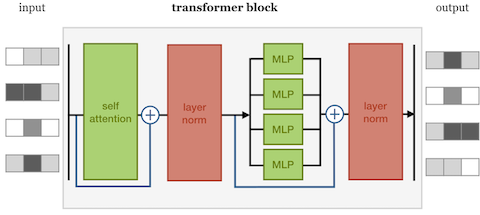

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, k, heads):
        """
        Basic transformer block.

        Args:
            k: embedding dimension
            heads: number of heads (k mod heads must be 0)

        """
        super(TransformerBlock, self).__init__()

        self.att = MultiHeadAttention(k, heads=heads)

        self.norm1 = nn.LayerNorm(k)

        self.ff = nn.Sequential(
            nn.Linear(k, 4 * k),
            nn.ReLU(),
            nn.Linear(4 * k, k))

        self.norm2 = nn.LayerNorm(k)

    def forward(self, x):
        """
        Forward pass of transformer block.

        Args:
            x: input with shape of (b, t, k)

        Returns:
            y: output with shape of (b, t, k)
        """
        ########################################################################
        #        TODO: Perform the forward pass of a transformer block         #
        #                       as depicted in the image.                      #
        ########################################################################

        y = x + self.att(x)

        y = self.norm1(y)

        y = y + self.ff(y)

        y = self.norm2(y)

        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################

        return y

## Unsupervised Learning

### AutoEncoder

In [ ]:
#encoder
class Encoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim):
        super(Encoder, self).__init__()

        ########################################################################
        #    TODO: Create the necessary layers                                 #
        ########################################################################

        """
        latent_dims: latent space dimension (int)
        s_img: size of square input image (int)
        hdim: dimensions of hidden layers (list)
        """
        self.linear1 = nn.Linear(s_img * s_img, hdim[0])
        self.linear2 = nn.Linear(hdim[0], hdim[1])
        self.linear3 = nn.Linear(hdim[1], latent_dims)
        self.relu = nn.ReLU()

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################


    def forward(self, x):

        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))

        ########################################################################
        #    TODO: Apply final layer of the enconder                           #
        #    NOTE: must you apply an activation, as before?                    #
        ########################################################################

        x = self.linear3(x)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return x

#decoder
class Decoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim):
        super(Decoder, self).__init__()

        self.linear1 = nn.Linear(latent_dims, hdim[1])
        self.linear2 = nn.Linear(hdim[1], hdim[0])
        self.linear3 = nn.Linear(hdim[0], s_img*s_img)
        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):

        ########################################################################
        #    TODO: Apply full forward function                                 #
        #    NOTE: Please have a close look at the forward function of the     #
        #    encoder                                                           #
        ########################################################################

        z = self.relu(self.linear1(z))
        z = self.relu(self.linear2(z))
        z = self.sigmoid(self.linear3(z))

        z = z.reshape(-1, 1, s_img, s_img)  # image channels = 1

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return z

#autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim = [100, 50]):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(latent_dims, s_img, hdim)
        self.decoder = Decoder(latent_dims, s_img, hdim)

    def forward(self, x):

        ########################################################################
        #    TODO: concatanate encoder and decoder                             #
        ########################################################################

        z = self.encoder(x)
        y = self.decoder(z)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        return y

### Variational Auto Encoders (VAE)

In [ ]:
#encoder
class VarEncoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim):
        super(VarEncoder, self).__init__()

        #layers for g1
        self.linear1_1 = nn.Linear(s_img*s_img, hdim[0])
        self.linear2_1 = nn.Linear(hdim[0], hdim[1])
        self.linear3_1 = nn.Linear(hdim[1], latent_dims)

        #layers for g2
        self.linear1_2 = nn.Linear(s_img*s_img, hdim[0])
        self.linear2_2 = nn.Linear(hdim[0], hdim[1])
        self.linear3_2 = nn.Linear(hdim[1], latent_dims)

        self.relu    = nn.ReLU()

        #distribution setup
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(try_gpu()) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(try_gpu())
        self.kl = 0

    ########################################################################
    #    TODO: Define function for:                                        #
    #    1. the Kullback-Leibner loss "kull_leib"                          #
    #    2. the Reparameterization trick                                   #
    ########################################################################

    def kull_leib(self, mu, sig):
        return (sig ** 2 + mu ** 2 - torch.log(sig) - 1/2).sum()

    def reparameterize(self, mu, sig):
        return mu + sig * self.N.sample(mu.shape)

    ########################################################################
    #                         END OF YOUR CODE                             #
    ########################################################################

    def forward(self, x):


        ########################################################################
        #    TODO: Compute mean and variance                                   #
        ########################################################################

        x = torch.flatten(x, start_dim=1)

        x1 = self.relu(self.linear1_1(x))
        x1 = self.relu(self.linear2_1(x1))
        x1 = self.linear3_1(x1)

        x2 = self.relu(self.linear1_2(x))
        x2 = self.relu(self.linear2_2(x2))
        x2 = self.linear3_2(x2)

        sig = torch.exp(x1)  ## !!!!!
        mu = x2

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        #reparameterize to find z
        z = self.reparameterize(mu, sig)

        #loss between N(0,I) and learned distribution
        self.kl = self.kull_leib(mu, sig)

        return z

#decoder: same as before

#autoencoder
class VarAutoencoder(nn.Module):
    def __init__(self, latent_dims, s_img, hdim = [100, 50]):
        super(VarAutoencoder, self).__init__()

        self.encoder = VarEncoder(latent_dims, s_img, hdim)
        self.decoder = Decoder(latent_dims, s_img, hdim)

    def forward(self, x):

        z = self.encoder(x)
        y = self.decoder(z)

        return y